In [ ]:
from google.colab import drive
#specify project directory in drive eg /content/drive/NLUProject
# drive.flush_and_unmount()
drive.mount('/content/drive')

#define necessary imports
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from torch.utils.data import Dataset, DataLoader

import gensim

Mounted at /content/drive


In [ ]:
# define the dataset 
class IMBDDataset(Dataset):
    """IMDB dataset."""

    # initialize the data in the dataset, pad the sequences to the max length
    def __init__(self, df):
        self.df = df
        self.maxLenForDF = self.getMaximumLengthSequence()
        self.padReturningItems(self.maxLenForDF)
        self.sendListToTensors()

# pad all of the sequences up to a given length
    def padReturningItems(self, lengthToPadTo):
        for index, row in self.df.iterrows():
            # if(index % 100 == 0):
            #   print(index)
            paddingNeeded = (lengthToPadTo - len(row['review_tokens_reduced']))
            if(paddingNeeded > 0):
                padData = [paddingID] * paddingNeeded
                self.df.at[index, "review_tokens_reduced"] = row['review_tokens_reduced'] + padData
# convert data that will go to the model into tensors
    def sendListToTensors(self):
        for index, row in self.df.iterrows():
            self.df.at[index, "review_tokens_reduced"] = torch.tensor(row['review_tokens_reduced'], dtype=torch.int)
            self.df.at[index, "user_id_transformed_to_label"] = torch.tensor(row['user_id_transformed_to_label'], dtype=torch.int)

    def __len__(self):
        return self.df.shape[0]

    def getMaximumLengthSequence(self):
        dfColumnAsList = self.df['review_tokens_reduced'].tolist()
        listOfListLengths = [len(i) for i in dfColumnAsList]
        return max(listOfListLengths)
# on getitem, return the row
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        dfRowToReturn = self.df.iloc[idx]
        dictToReturn = {'input': dfRowToReturn['review_tokens_reduced'], 'label': dfRowToReturn['user_id_transformed_to_label']}
        #print(dictToReturn)
        return dictToReturn
#get the number of unique authors
    def getAuthorCount(self):
        uniqueAuthors = self.df["user_id_transformed_to_label"].unique()
        uniqueAuthorLength = len(uniqueAuthors)
        return uniqueAuthorLength
# Siamese Dataset

class IMBDSiameseDataset(Dataset):
    """IMDB dataset for siamese implementation."""

    def __init__(self, df):
        self.df = df
        self.maxLenForDF = self.getMaximumLengthSequence()
        self.padReturningItems(self.maxLenForDF)
        self.sendListToTensors()

    def padReturningItems(self, lengthToPadTo):
        for index, row in self.df.iterrows():
            # if(index % 100 == 0):
            #   print(index)
            paddingNeeded = (lengthToPadTo - len(row['review_tokens_reduced']))
            if(paddingNeeded > 0):
                padData = [paddingID] * paddingNeeded
                self.df.at[index, "review_tokens_reduced"] = row['review_tokens_reduced'] + padData

    def sendListToTensors(self):
        for index, row in self.df.iterrows():
            self.df.at[index, "review_tokens_reduced"] = torch.tensor(row['review_tokens_reduced'], dtype=torch.int)
            self.df.at[index, "user_id_transformed_to_label"] = torch.tensor(row['user_id_transformed_to_label'], dtype=torch.int)

    def __len__(self):
        return self.df.shape[0]

    def getMaximumLengthSequence(self):
        dfColumnAsList = self.df['review_tokens_reduced'].tolist()
        listOfListLengths = [len(i) for i in dfColumnAsList]
        return max(listOfListLengths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input1 = self.df.sample()

        should_get_same_class = np.random.randint(0,2) 
        if should_get_same_class:
            while True:
                input2 = self.df.sample()
                if input1['user_id_transformed_to_label'].iloc[0] == input2['user_id_transformed_to_label'].iloc[0]:
                    break
        else:

            while True:
                input2 = self.df.sample()
                if input1['user_id_transformed_to_label'].iloc[0] != input2['user_id_transformed_to_label'].iloc[0]:
                    break


        dictToReturn = {'input1': input1['review_tokens_reduced'].iloc[0], 'label1': input1['user_id_transformed_to_label'].iloc[0], 
                        'input2': input2['review_tokens_reduced'].iloc[0], 'label2': input2['user_id_transformed_to_label'].iloc[0], 
                        'same_class' : int(input1['user_id_transformed_to_label'].iloc[0] == input2['user_id_transformed_to_label'].iloc[0])}
        return dictToReturn
        
    def getAuthorCount(self):
        uniqueAuthors = self.df["user_id_transformed_to_label"].unique()
        uniqueAuthorLength = len(uniqueAuthors)
        return uniqueAuthorLength


In [ ]:
# load in the datasets
# train_dataset = torch.load('drive/MyDrive/NLU Project/data/PyTorchDataset/IMDBtrain.pt')
# validate_dataset = torch.load('drive/MyDrive/NLU Project/data/PyTorchDataset/IMDBvalidate.pt')
test_dataset = torch.load('drive/MyDrive/NLU Project/data/PyTorchDataset/IMDBtest.pt')
# siamese_train_dataset = torch.load('drive/MyDrive/NLU Project/data/PyTorchDataset/IMDBtrainSiamese.pt')
# siamese_validate_dataset = torch.load('drive/MyDrive/NLU Project/data/PyTorchDataset/IMDBvalidateSiamese.pt')
siamese_test_dataset = torch.load('drive/MyDrive/NLU Project/data/PyTorchDataset/IMDBtestSiamese.pt')

In [ ]:
#LSTM DEFINITION
#define the model
class LSTMModel(torch.nn.Module):

  def __init__(self, pretrainedEmbeddingWeights, lstmHiddenDimensions, lstmLayerNumber, outputClassNumber, paddingId):
    super(LSTMModel, self).__init__()
    self.EmbeddingLayer = nn.Embedding.from_pretrained(pretrainedEmbeddingWeights, padding_idx = paddingId)
    self.EmbeddingDimensions = pretrainedEmbeddingWeights.size()[1]
    self.LSTMLayer = nn.LSTM(self.EmbeddingDimensions, lstmHiddenDimensions, batch_first=True)
    self.LinearLayer = nn.Linear(lstmHiddenDimensions, outputClassNumber)
    self.nnSoftMax = nn.LogSoftmax()

  def forward(self, input):
    embeddedInput = self.EmbeddingLayer(input)
    lstmOutput, (finalHiddenStates, finalCellStates) = self.LSTMLayer(embeddedInput)
    lstmOutsPooled = torch.mean(lstmOutput, dim=1)
    linearOutput = self.LinearLayer(lstmOutsPooled)
    softMaxOut = self.nnSoftMax(linearOutput)
    return softMaxOut
#GRU DEFINITION
class GRUModel(torch.nn.Module):

  def __init__(self, pretrainedEmbeddingWeights, gruHiddenDimensions, gruLayerNumber, outputClassNumber, paddingId):
    super(GRUModel, self).__init__()
    self.EmbeddingLayer = nn.Embedding.from_pretrained(pretrainedEmbeddingWeights, padding_idx = paddingId)
    self.EmbeddingDimensions = pretrainedEmbeddingWeights.size()[1]
    self.GRULayer = nn.GRU(self.EmbeddingDimensions, gruHiddenDimensions, batch_first=True)
    self.LinearLayer = nn.Linear(gruHiddenDimensions, outputClassNumber)
    self.nnSoftMax = nn.LogSoftmax()

  def forward(self, input):
    embeddedInput = self.EmbeddingLayer(input)
    gruOutput, finalHiddenStates = self.GRULayer(embeddedInput)
    gruOutsPooled = torch.mean(gruOutput, dim=1)
    linearOutput = self.LinearLayer(gruOutsPooled)

    softMaxOut = self.nnSoftMax(linearOutput)
    # print(softMaxOut.size())
    return softMaxOut

#SIAMESE DEFINITION
class SiameseModel(torch.nn.Module):

  def __init__(self, pretrainedEmbeddingWeights, gruHiddenDimensions, gruLayerNumber, outputClassNumber, paddingId):
    super(SiameseModel, self).__init__()
    self.EmbeddingLayer = nn.Embedding.from_pretrained(pretrainedEmbeddingWeights, padding_idx = paddingId)
    self.EmbeddingDimensions = pretrainedEmbeddingWeights.size()[1]
    self.GRULayer = nn.GRU(self.EmbeddingDimensions, gruHiddenDimensions, batch_first=True)
    self.LinearLayer = nn.Linear(gruHiddenDimensions, outputClassNumber)
    self.nnSoftMax = nn.LogSoftmax()

  def network_forward(self, input):
    embeddedInput = self.EmbeddingLayer(input)
    gruOutput, finalHiddenStates = self.GRULayer(embeddedInput)
    gruOutsPooled = torch.mean(gruOutput, dim=1)
    linearOutput = self.LinearLayer(gruOutsPooled)

    softMaxOut = self.nnSoftMax(linearOutput)
    return softMaxOut

  def forward(self, input1, input2):
    output1 = self.network_forward(input1)
    output2 = self.network_forward(input2)

    return output1, output2
  def getLoss(self, input1, input2, label, real1, real2):

    output1 = self.network_forward(input1)
    output2 = self.network_forward(input2)

    out1ModelPredictionLoss = torch.nn.functional.nll_loss(output1, real1)
    out2ModelPredictionLoss = torch.nn.functional.nll_loss(output2, real2)

    similarityMeasures = torch.nn.functional.cosine_similarity(output1, output2, dim=1)

    similarityLoss = torch.mean(((1-label) * similarityMeasures) +          #if they are different, we want no similarity, so use the measure as loss
                                ((label) * torch.absolute(torch.sub(similarityMeasures, 1))))            #if they are the same we want the similarity to be 1, so add loss as |result-1|


    #increase the 0-1 range of simLoss to 0-5
    normalizedLoss = 5*(similarityLoss)

    fullLoss = out1ModelPredictionLoss + out2ModelPredictionLoss + normalizedLoss
    return fullLoss

  def singleForward(self, input):
    embeddedInput = self.EmbeddingLayer(input)
    gruOutput, finalHiddenStates = self.GRULayer(embeddedInput)
    gruOutsPooled = torch.mean(gruOutput, dim=1)
    linearOutput = self.LinearLayer(gruOutsPooled)

    softMaxOut = self.nnSoftMax(linearOutput)
    return softMaxOut

In [ ]:
#initialize and load in model weights
model = gensim.models.KeyedVectors.load('drive/MyDrive/NLU Project/data/preProcessedEmbeddings/glove_vectors.kv')
unknownToken = "<unk>"
padToken = "<pad>"
paddingID = model.vocab[padToken].index
preTrainedEmbeddings = torch.from_numpy(model.vectors)
hiddnSize = 64
layers = 3
outputSize = test_dataset.getAuthorCount()
outputSizeSiamese = siamese_test_dataset.getAuthorCount()


LSTMModel = LSTMModel(preTrainedEmbeddings, hiddnSize, layers, outputSize, paddingID)
LSTMModel.float()
GRUModel = GRUModel(preTrainedEmbeddings, hiddnSize, layers, outputSize, paddingID)
GRUModel.float()
siameseModel = SiameseModel(preTrainedEmbeddings, hiddnSize, layers, outputSizeSiamese, paddingID)
siameseModel.float()
# prevent the notebook from outputting last line
print()

In [ ]:
LSTMModel.load_state_dict(torch.load('drive/MyDrive/NLU Project/models/modelLSTMIMDB'))
GRUModel.load_state_dict(torch.load('drive/MyDrive/NLU Project/models/modelGRUIMDB'))
siameseModel.load_state_dict(torch.load('drive/MyDrive/NLU Project/models/modelSiameseIMDB'))

<All keys matched successfully>

In [ ]:
# Model evaluation, get accuracy for all 3 models on the test set

#define the function
def get_accuracy(dataloader, model):

  model.eval()
  correctlyPredictedNum = 0
  acummulateLength = 0

  for i, data in enumerate(dataloader):
    modelOutputOnSampleBatch = model(data['input'])
    classPredictions = np.argmax(modelOutputOnSampleBatch.detach().numpy(), axis=1)
    correctBoolean = classPredictions == data['label'].detach().numpy()
    correctlyPredictedNum += np.sum(correctBoolean)
    acummulateLength+= data['input'].size(0)
  accuracyToReturn = correctlyPredictedNum / acummulateLength
  model.train()

  return accuracyToReturn
def get_accuracy_Siamese(dataloader, model):

  model.eval()
  correctlyPredictedNum = 0
  acummulateLength = 0

  for i, data in enumerate(dataloader):
    modelOutputOnSampleBatch = model.singleForward(data['input'])
    classPredictions = np.argmax(modelOutputOnSampleBatch.detach().numpy(), axis=1)
    correctBoolean = classPredictions == data['label'].detach().numpy()
    correctlyPredictedNum += np.sum(correctBoolean)
    acummulateLength+= data['input'].size(0)
  accuracyToReturn = correctlyPredictedNum / acummulateLength
  model.train()

  return accuracyToReturn

In [ ]:
batchSize=64
test_dataloader = DataLoader(test_dataset, batch_size=batchSize)

In [ ]:
print("LSTM Accuracy:", get_accuracy(test_dataloader, LSTMModel))
print("GRU Accuracy:", get_accuracy(test_dataloader, GRUModel))
print("Siamese Accuracy:", get_accuracy_Siamese(test_dataloader, siameseModel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LSTM Accuracy: 0.854516129032258


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


GRU Accuracy: 0.886021505376344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Siamese Accuracy: 0.8680645161290322


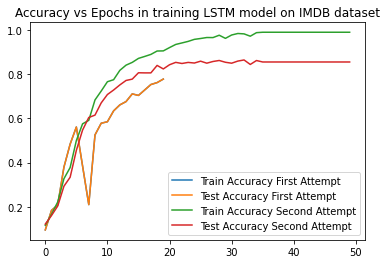

In [ ]:
#load the lists generated during evaluation LSTM
with open('drive/MyDrive/NLU Project/evaluation-lists/trainListSecondTry_LSTMIMDB', 'rb') as file:
     lstmTrainList2 = pickle.load(file)
with open('drive/MyDrive/NLU Project/evaluation-lists/testListSecondTry_LSTMIMDB', 'rb') as file:
     lstmTestList2 = pickle.load(file)
with open('drive/MyDrive/NLU Project/evaluation-lists/testList_LSTMIMDB', 'rb') as file:
     lstmTrainList1 = pickle.load(file)
with open('drive/MyDrive/NLU Project/evaluation-lists/testList_LSTMIMDB', 'rb') as file:
     lstmTestList1 = pickle.load(file)
#Plot training outputs on each model
epochRange1 = np.arange(len(lstmTestList1))
epochRange2 = np.arange(len(lstmTestList2))
plt.plot(epochRange1, lstmTrainList1, label = "Train Accuracy First Attempt")
plt.plot(epochRange1, lstmTestList1, label = "Test Accuracy First Attempt")
plt.plot(epochRange2, lstmTrainList2, label = "Train Accuracy Second Attempt")
plt.plot(epochRange2, lstmTestList2, label = "Test Accuracy Second Attempt")
plt.title("Accuracy vs Epochs in training LSTM model on IMDB dataset")
plt.legend()
plt.show()

#No change past EPOCH 32 due to training time ending


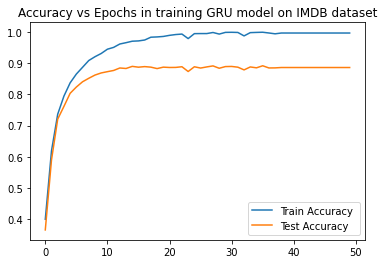

In [ ]:
#load the lists generated during evaluation GRU
with open('drive/MyDrive/NLU Project/evaluation-lists/GRUTRAINLIST', 'rb') as file:
     gruTrainList = pickle.load(file)
with open('drive/MyDrive/NLU Project/evaluation-lists/GRUTESTLIST', 'rb') as file:
     gruTestList = pickle.load(file)
#Plot training outputs on each model
epochRange = np.arange(len(gruTrainList))
plt.plot(epochRange, gruTrainList, label = "Train Accuracy ")
plt.plot(epochRange, gruTestList, label = "Test Accuracy ")
plt.title("Accuracy vs Epochs in training GRU model on IMDB dataset")
plt.legend()
plt.show()

#No change past EPOCH 38 due to training time ending


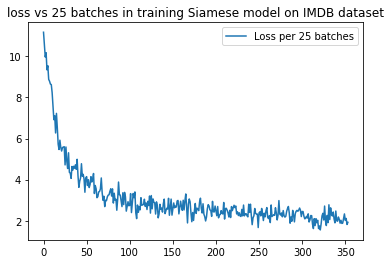

In [ ]:
#generated from the text output of during model training
with open('drive/MyDrive/NLU Project/evaluation-lists/SiameseIMDBLoss', 'rb') as file:
     siamLossList = pickle.load(file)
#Plot training outputs on each model
Batches25 = np.arange(len(siamLossList))
plt.plot(Batches25, siamLossList, label = "Loss per 25 batches")
plt.title("loss vs 25 batches in training Siamese model on IMDB dataset")
plt.legend()
plt.show()